In [17]:
#import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [18]:
#Load all databases
df_ratings = pd.read_csv("../data/ratings.csv")
df_movies = pd.read_csv("../data/movies.csv", index_col = 0)
df_tags = pd.read_csv("../data/tags.csv")
df_links = pd.read_csv("../data/links.csv")
df_genometags = pd.read_csv("../data/genome-tags.csv", index_col = 0)
df_genome_scores = pd.read_csv("../data/genome-scores.csv")

In [19]:
#creating a new column in df_movies, displaying the average rating users gave the movie
ratings = df_ratings.groupby("movieId")["rating"].mean()
df_movies = df_movies.merge(ratings, on = "movieId")
df_movies = df_movies.rename({"rating":"avg_rating"}, axis = 1)
df_movies

In [51]:
movies_with_genomes

,movieId,title,genres,avg_rating,overall_genomescores
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.921240,180.73100
1128,2,Jumanji (1995),Adventure|Children|Fantasy,3.211977,134.78025
2256,3,Grumpier Old Men (1995),Comedy|Romance,3.151040,104.23100
3384,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.861393,96.36150
4512,5,Father of the Bride Part II (1995),Comedy,3.064592,111.50625
...,...,...,...,...,...
11691720,130578,The Gunman (2015),Action|Thriller,3.000000,69.40650
11692848,130840,Spring (2015),Horror|Romance|Sci-Fi,3.500000,136.69300
11693976,131013,Get Hard (2015),Comedy,2.500000,109.56900
11695104,131168,Phoenix (2014),Drama,3.500000,154.19225


In [52]:
df_movies

,title,genres,avg_rating
movieId,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.921240
2,Jumanji (1995),Adventure|Children|Fantasy,3.211977
3,Grumpier Old Men (1995),Comedy|Romance,3.151040
4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.861393
5,Father of the Bride Part II (1995),Comedy,3.064592
...,...,...,...
131254,Kein Bund für's Leben (2007),Comedy,4.000000
131256,"Feuer, Eis & Dosenbier (2002)",Comedy,4.000000
131258,The Pirates (2014),Adventure,2.500000


# Genome Tag Graph

In [21]:
#creating a new dataframe, df_movie_genomescores, that shows all 1128 available genome scores for each movie 
df_movie_genomescores = pd.merge(df_movies, df_genome_scores, on = "movieId")

#mapping the names from the table df_genometags to the genome tag ids in the df_movie_genomescores df
df_movie_genomescores["genome_tag"] = df_movie_genomescores["tagId"].map(df_genometags["tag"])

#creating a new column, relevance_sum, a sum of all relevance scores for every movie, showing how "common" a genome tag is
genomescore_sums = df_movie_genomescores.groupby("genome_tag")["relevance"].sum().sort_values(ascending = False)
df_movie_genomescores = df_movie_genomescores.merge(genomescore_sums, on = "genome_tag")
df_movie_genomescores.rename({"relevance_x" : "inv_relevance", "relevance_y" : "relevance_sum"}, axis = 1,  inplace = True)
                            
#creating a new dataframe, movies_with_genomes, listing all movies that actually have genome tags. Not all movies in df_movies have genome tags
movies_with_genomes = df_movie_genomescores.drop_duplicates(subset=["movieId"])
movies_with_genomes.drop(["tagId", "inv_relevance", "genome_tag", "relevance_sum"], axis = 1, inplace = True)

#creating a new column "overall_genomescores" in df_movie_genomescores, displaying the overall sum of genometag scores. This is used to scale genometags within a single movie
overall_genomescore = []
for j, movie in movies_with_genomes.iterrows():
    sum = df_movie_genomescores.loc[df_movie_genomescores["movieId"] == movie["movieId"]]["inv_relevance"].sum()
    overall_genomescore.append(sum)
movies_with_genomes["overall_genomescores"] = overall_genomescore

#merging the column "overall_genomescores" from movies_with_genomes
df_movie_genomescores = df_movie_genomescores.merge(movies_with_genomes[["movieId", "overall_genomescores"]], on="movieId")

#creating the column "genome_effect_on_rating", describing how each genomescore relates to the avg_rating of its movie
df_movie_genomescores["genome_effect_on_rating"] = np.round((df_movie_genomescores["inv_relevance"]/ df_movie_genomescores["overall_genomescores"]), 20) * df_movie_genomescores["avg_rating"]

#dropna values that came from round errors
df_movie_genomescores.dropna(inplace=True)

In [22]:
#creating a new DataFrame, genome_rating, grouping the df_movie_genomescores on the genome_tag, leaving us with a df of only the 1128 genome tags and its relevant values
genome_rating = df_movie_genomescores.groupby(["genome_tag","relevance_sum"])["genome_effect_on_rating"].sum().reset_index(name =  'rating_amount')
a = 33849.582297801215 #sum of all ratings
b = 1128 #number of genome tags
genome_rating["avg_rating"] =  ((genome_rating["rating_amount"] / genome_rating["relevance_sum"] ) * a)/b *5 #multiplying by 5 to get the same scale as avg_rating on df_movies

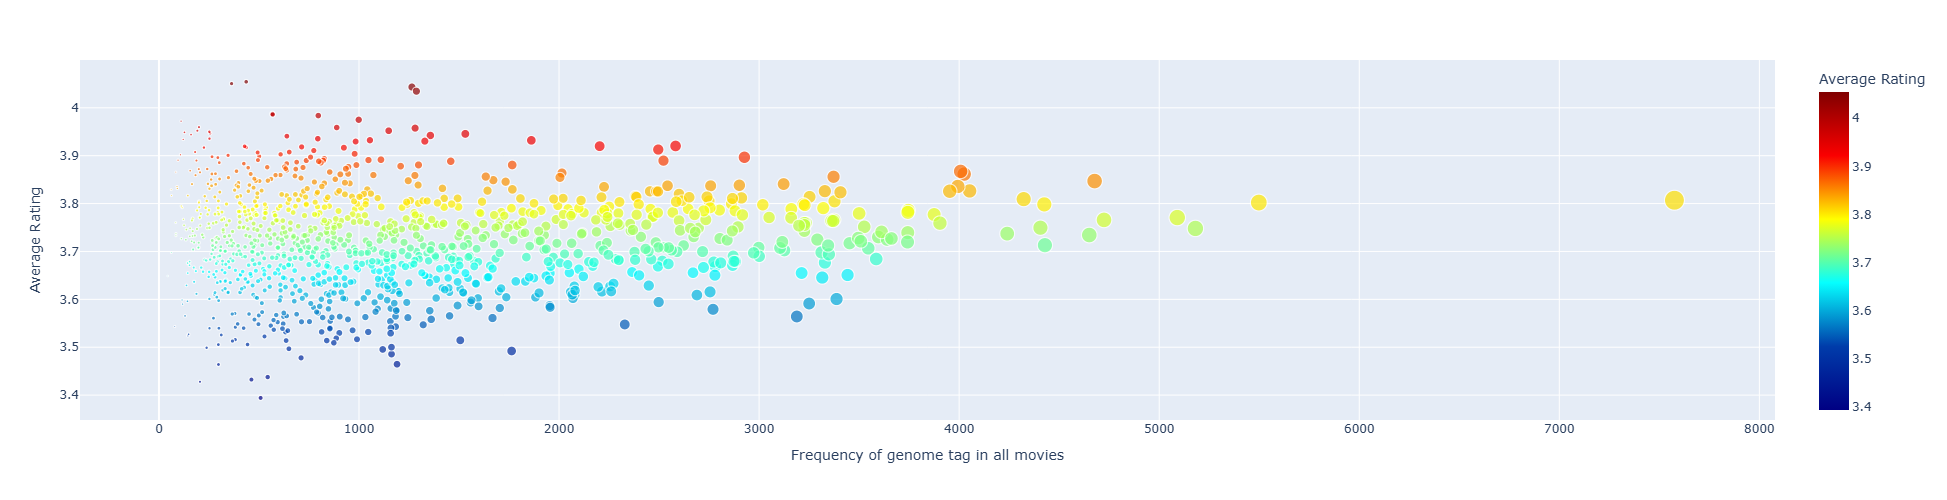

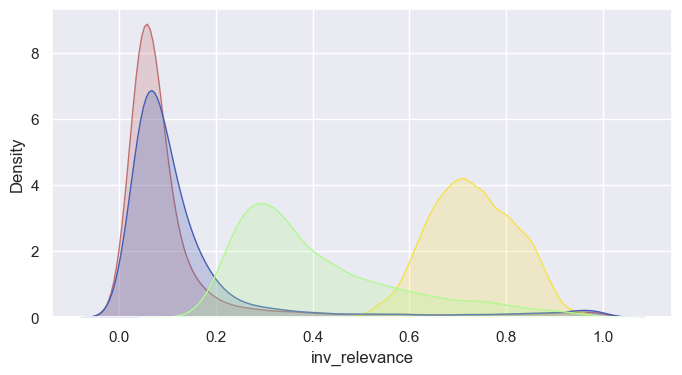

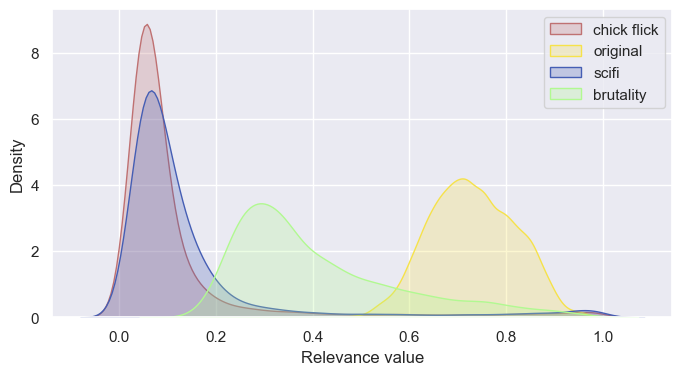

In [50]:
#creating the figure "Genome Tag average Rating" graph
fig = px.scatter(genome_rating, y = "avg_rating", x = "relevance_sum", size = "relevance_sum", color = "avg_rating", color_continuous_scale=px.colors.sequential.Jet,hover_data=["genome_tag"], labels = {"avg_rating" : "Average Rating",
                                                                                                                                                                                                          "relevance_sum" : "Frequency of genome tag in all movies"})
fig.update_layout(height = 500, width=800)
fig.show()
def genome_graph(genome):
    df = df_movie_genomescores.loc[df_movie_genomescores["genome_tag"] == genome].sort_values(["inv_relevance"], ascending = False)
    #df["quantile"] = pd.qcut(df["inv_relevance"], q=4, labels = ["low", "medium", "high", "highest"], duplicates = "drop")
    return df
cf = genome_graph("chick flick")
scifi = genome_graph("scifi")
og = genome_graph("original")
brute = genome_graph("brutality")

fig, ax = plt.subplots(figsize=(8,4))
sns.kdeplot(cf["inv_relevance"], label = "chick flick", fill = True, color = "#bf7172")
sns.kdeplot(og["inv_relevance"], label = "original", fill = True, color = "#f6e24a")
sns.kdeplot(scifi["inv_relevance"], label = "scifi", fill = True, color = "#455eb4")
sns.kdeplot(brute["inv_relevance"], label = "brutality", fill = True, color = "#b1f991")
ax.set(xlabel = "Relevance value")
plt.legend()
plt.show()

The first graph shows the Average Rating for each genome tag. The average rating here is derived from a function of the relevance of each tag, with the average rating of each movie with genome ratings.
A genome tag g (for example, the most common tag "original") is compared to all other tags in a movie. We get the sum of all "relevance" scores for each tag for the movie, then figure out what percentage of that sum the tag g represents. 
Then we devide up the average rating r of the Movie among all tags, including our tag g. 
If for example, g's relevance would make up 20% of the relevance of all genome tags in the movie, then it would "receive" 20% of the rating's score (in the case of a 5/5 rating, it would receive a value of 1, aka 20%).
We then scale this value to account for how tags are more or less common and then derive the average rating from there.

In the graph we can clearly see a trend, that is how the average rating evens out as the genome tag becomes more common (further right on the X-axis).
This would be logical, as a higher sample of movies would lead to the average rating moving more towards the mean.
We can see this clearly with the genome tags "original" (yellow, furthest extreme on the right of the X-axis). The distribution from graph #2 shows that this tag has a very high distribution on high relevance ratings.

On the contrary, the outliers on the Y-axis chick flick (positive Y), and scifi (negative Y), seem to have a very high distribution of ratings in the 0.1 range. This seems to imply that a distribution on the lower end makes the average rating less stable.



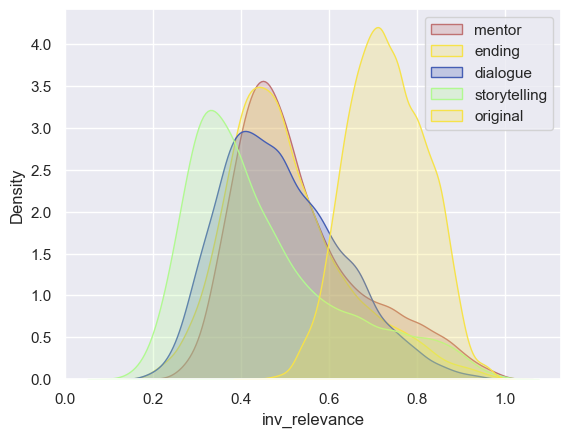

In [8]:
mentor = genome_graph("mentor")
ending = genome_graph("great ending")
dialogue = genome_graph("dialogue")
storytelling = genome_graph("storytelling")

sns.kdeplot(mentor["inv_relevance"], label = "mentor", fill = True, color = "#bf7172")
sns.kdeplot(ending["inv_relevance"], label = "ending", fill = True, color = "#f6e24a")
sns.kdeplot(dialogue["inv_relevance"], label = "dialogue", fill = True, color = "#455eb4")
sns.kdeplot(storytelling["inv_relevance"], label = "storytelling", fill = True, color = "#b1f991")
sns.kdeplot(og["inv_relevance"], label = "original", fill = True, color = "#f6e24a")
plt.legend()
plt.show()